In [362]:
%reload_ext autoreload
%autoreload 2
%matplotlib widget

In [363]:
import torch

In [364]:
import bnn.data
import bnn.functions
import bnn.layer
import bnn.loss
import bnn.network
import bnn.optimizer

In [365]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Setup

In [366]:
forward_func = bnn.functions.forward.SignBinarise()
#forward_func=bnn.functions.forward.LayerMeanBinarise()
#forward_func=bnn.functions.forward.LayerMedianBinarise()

In [367]:
backward_func = bnn.functions.backward.SignTernarise()
#backward_func = bnn.functions.backward.StochasticTernarise()
#backward_func = bnn.functions.backward.LayerMeanStdTernarise(half_range_stds=0.5)
#backward_func = bnn.functions.backward.LayerQuantileTernarise(lo=0.25, hi=0.75)
#backward_func = bnn.functions.backward.LayerQuantileSymmetricTernarise(prop_zero=0.33)

In [368]:
INPUT_DIM = 128
OUTPUT_DIM = 8

In [369]:
HIDDEN_DIM = INPUT_DIM
NUM_LAYERS = 10

In [370]:
dims = [INPUT_DIM] + [HIDDEN_DIM] * (NUM_LAYERS - 1) + [OUTPUT_DIM]

In [371]:
proj_TBNN = bnn.network.TernBinNetwork(
    dims,
    forward_func=forward_func,
    backward_func=backward_func,
)

In [372]:
noproj_TBNN = bnn.network.TernBinNetwork(
    dims,
    forward_func=forward_func,
    backward_func=bnn.functions.backward.ActualGradient(),
)

### Helper Funcs

In [373]:
def copy_weights(source: bnn.network.TernBinNetwork, target: bnn.network.TernBinNetwork):
    for name, layer in source.layers.items():
        target.layers[name].W.data = layer.W.data

In [374]:
def assert_same_weights(source: bnn.network.TernBinNetwork, target: bnn.network.TernBinNetwork):
    for name, layer in source.layers.items():
        assert torch.equal(target.layers[name].W.data, layer.W.data)

In [375]:
def grad_sign_confmats(
    input: torch.Tensor, 
    grad: torch.Tensor, 
    net1: bnn.network.TernBinNetwork, 
    net2: bnn.network.TernBinNetwork,
) -> dict[str, torch.Tensor]:
    # forward
    net1.forward(input)
    net2.forward(input)

    # backward
    net1.backward(grad)
    net2.backward(grad)

    confmats = {}
    for name in net1.layers:
        confmat = _grad_sign_confmat(net1.grad[name], net2.grad[name])
        confmats[name] = confmat
    
    return confmats


def _grad_sign_confmat(out1, out2):
    sign_out1 = torch.sign(out1)
    sign_out2 = torch.sign(out2)

    out = torch.empty(size=[3, 3])

    SYMBOLS = (-1, 0, 1)
    for i in SYMBOLS:
        for j in SYMBOLS:
            out[i, j] = torch.sum(sign_out2[sign_out1 == i] == j)

    out /= out.sum()
    return out


In [376]:
def print_confmat(confmat: torch.Tensor):
    print(
        "\t Actual grad sign\n"
        "\t 0 \t 1 \t -1 \t sum\n"
        "----------------------------------\n"
        f" 0  |\t {confmat[0, 0]:.3f} \t {confmat[1, 0]:.3f} \t {confmat[-1, 0]:.3f} \t| {confmat[:, 0].sum():.3f}\n"
        f" 1  |\t {confmat[0, 1]:.3f} \t {confmat[1, 1]:.3f} \t {confmat[-1, 1]:.3f} \t| {confmat[:, 1].sum():.3f}\n"
        f"-1  |\t {confmat[0, -1]:.3f} \t {confmat[1, -1]:.3f} \t {confmat[-1, -1]:.3f} \t| {confmat[:, -1].sum():.3f}\n"
        "----------------------------------\n"
        f"sum |\t {confmat[0, :].sum():.3f} \t {confmat[1, :].sum():.3f} \t {confmat[-1, :].sum():.3f} \t| {confmat.sum():.3f}\n"
    )

In [377]:
def confmat_nonzero_sign_error(confmat) -> float:
    nonzero = confmat[1].sum() + confmat[-1].sum()
    wrong_sign = confmat[1, -1] + confmat[-1, 1]

    prop = wrong_sign / nonzero

    return prop.item()

def confmat_nonzero_sign_error_inc0(confmat) -> float:
    nonzero = confmat[1].sum() + confmat[-1].sum()
    wrong_sign = confmat[1, -1] + confmat[-1, 1]
    zero = confmat[1, 0] + confmat[-1, 0]

    prop = (wrong_sign + zero) / nonzero

    return prop.item()

def confmat_tern_grad_wrong_sign(confmat) -> float:
    nonzero = confmat[:, 1].sum() + confmat[:, -1].sum()
    wrong_sign = confmat[1, -1] + confmat[-1, 1]

    prop = wrong_sign / nonzero

    return prop.item()

### Initialise

In [378]:
stable_zero_prob = 0.99 * (1 - 1/HIDDEN_DIM)
proj_TBNN._initialise(W_mean=0, W_zero_prob=stable_zero_prob)
list(proj_TBNN.layers.values())[-1]._initialise_W(mean=0, zero_prob=0.33)

In [379]:
copy_weights(source=proj_TBNN, target=noproj_TBNN)
assert_same_weights(source=proj_TBNN, target=noproj_TBNN)

### Check gradients

In [380]:
list(noproj_TBNN.layers.values())[0].W.dtype

torch.int64

In [381]:
NUM_SAMPLES = 1024
input = bnn.random.generate_random_binary_tensor(shape=[NUM_SAMPLES, INPUT_DIM], mean=0)
grad = bnn.random.generate_random_binary_tensor(shape=[NUM_SAMPLES, OUTPUT_DIM], mean=0)

confmats = grad_sign_confmats(input=input, grad=grad, net1=noproj_TBNN, net2=proj_TBNN)

for name, confmat in confmats.items():
    print("layer: ", name)
    print_confmat(confmat)

layer:  TernBinLayer0
	 Actual grad sign
	 0 	 1 	 -1 	 sum
----------------------------------
 0  |	 0.151 	 0.127 	 0.108 	| 0.386
 1  |	 0.001 	 0.240 	 0.081 	| 0.322
-1  |	 0.001 	 0.087 	 0.204 	| 0.292
----------------------------------
sum |	 0.153 	 0.453 	 0.393 	| 1.000

layer:  TernBinLayer1
	 Actual grad sign
	 0 	 1 	 -1 	 sum
----------------------------------
 0  |	 0.136 	 0.119 	 0.112 	| 0.367
 1  |	 0.002 	 0.234 	 0.076 	| 0.313
-1  |	 0.003 	 0.075 	 0.243 	| 0.321
----------------------------------
sum |	 0.141 	 0.428 	 0.431 	| 1.000

layer:  TernBinLayer2
	 Actual grad sign
	 0 	 1 	 -1 	 sum
----------------------------------
 0  |	 0.115 	 0.125 	 0.121 	| 0.361
 1  |	 0.005 	 0.235 	 0.074 	| 0.314
-1  |	 0.004 	 0.068 	 0.253 	| 0.325
----------------------------------
sum |	 0.123 	 0.429 	 0.448 	| 1.000

layer:  TernBinLayer3
	 Actual grad sign
	 0 	 1 	 -1 	 sum
----------------------------------
 0  |	 0.156 	 0.106 	 0.122 	| 0.383
 1  |	 0.005 	 0.2

In [382]:
for name, confmat in confmats.items():
    print("layer: ", name)
    print(f"nonzero wrong sign prop: {confmat_nonzero_sign_error(confmat):.3f}")
    print(f"nonzero wrong sign (inc0) prop: {confmat_nonzero_sign_error_inc0(confmat):.3f}")
    print(f"nonzero tern grad wrong sign: {confmat_tern_grad_wrong_sign(confmat):.3f}")

layer:  TernBinLayer0
nonzero wrong sign prop: 0.198
nonzero wrong sign (inc0) prop: 0.475
nonzero tern grad wrong sign: 0.273
layer:  TernBinLayer1
nonzero wrong sign prop: 0.176
nonzero wrong sign (inc0) prop: 0.444
nonzero tern grad wrong sign: 0.239
layer:  TernBinLayer2
nonzero wrong sign prop: 0.162
nonzero wrong sign (inc0) prop: 0.443
nonzero tern grad wrong sign: 0.222
layer:  TernBinLayer3
nonzero wrong sign prop: 0.144
nonzero wrong sign (inc0) prop: 0.416
nonzero tern grad wrong sign: 0.194
layer:  TernBinLayer4
nonzero wrong sign prop: 0.126
nonzero wrong sign (inc0) prop: 0.387
nonzero tern grad wrong sign: 0.166
layer:  TernBinLayer5
nonzero wrong sign prop: 0.098
nonzero wrong sign (inc0) prop: 0.346
nonzero tern grad wrong sign: 0.126
layer:  TernBinLayer6
nonzero wrong sign prop: 0.069
nonzero wrong sign (inc0) prop: 0.289
nonzero tern grad wrong sign: 0.085
layer:  TernBinLayer7
nonzero wrong sign prop: 0.041
nonzero wrong sign (inc0) prop: 0.231
nonzero tern grad wr

In [383]:
# Metrics
## Not sooo bad if there is an incorrect zero gradient...
## What is bad is a gradient being the wrong sign

## What proportion of the nonzero binarised gradients are the wrong sign?

In [384]:
# Plot
## x-axis layer
## y-axis prop. incorrect gradient
## different lines for different ternarisation methods

In [385]:
import matplotlib.pyplot as plt

import bnn.metrics

In [386]:
noproj_grad_ds: list[bnn.random.DISCRETE_DIST | None] = []
for grad in noproj_TBNN.grad.values():
    d = bnn.metrics.distribution(grad.cpu())
    noproj_grad_ds.append(d)
    
proj_grad_ds: list[bnn.random.DISCRETE_DIST | None] = []
for grad in proj_TBNN.grad.values():
    d = bnn.metrics.distribution(grad.cpu())
    proj_grad_ds.append(d)

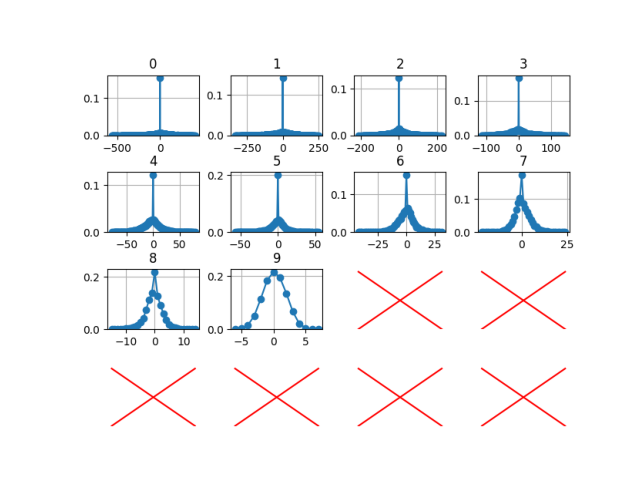

In [387]:
image = bnn.metrics.distribution_plot(noproj_grad_ds)

FIG_NAME = "noproj_grad_dist"

plt.close(FIG_NAME)
plt.figure(FIG_NAME)
plt.imshow(image)
plt.axis('off')
plt.show()

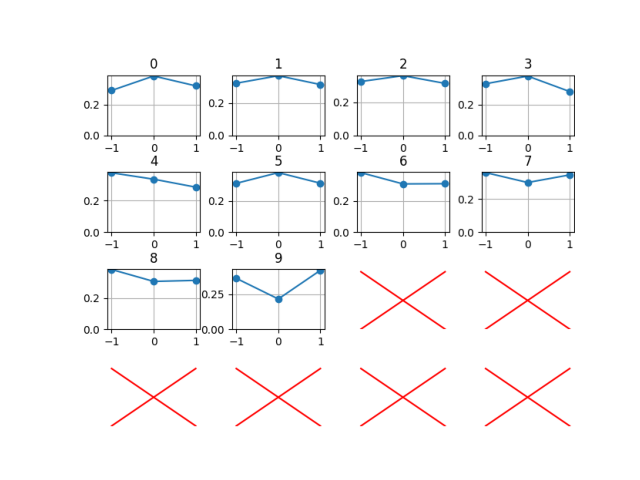

In [388]:
image = bnn.metrics.distribution_plot(proj_grad_ds)

FIG_NAME = "grad_dist"

plt.close(FIG_NAME)
plt.figure(FIG_NAME)
plt.imshow(image)
plt.axis('off')
plt.show()